In [1]:
import os
current_dir = os.getcwd()
parent_dir = os.path.abspath(os.path.join(current_dir,os.pardir))
os.chdir(parent_dir)

In [2]:
import numpy as np
import pandas as pd
import torch
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from vae_earlystopping import EarlyStopping
from model.m26_no import MultiDecoderCondVAE
from loss.l26oss_all import integrated_loss_fn


In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [4]:
train_loader = torch.load('torch/retrain_loader.pt',weights_only=False)
val_loader = torch.load('torch/reval_loader.pt',weights_only=False)
test_loader = torch.load('torch/retest_loader.pt',weights_only=False)


In [5]:
x_sample,c_sample = next(iter(train_loader))
x_dim = x_sample.shape[1]
c_dim = c_sample.shape[1]
x_dim,c_dim

(23, 9)

In [6]:
model = MultiDecoderCondVAE(x_dim,c_dim,z_dim=8).to(device)
early_stopping = EarlyStopping(patience=40,min_delta = 1e-9)
optimizer = optim.Adam(model.parameters(),lr = 1e-3, weight_decay=1e-5)

In [7]:
history = {'train_loss':[],'train_bce':[],'train_mse':[],'train_kl':[],'val_loss':[],'val_bce':[],'val_mse':[],'val_kl':[]}
epochs = 600

In [8]:
for epoch in range(1,epochs+1):
    model.train()
    t_loss,t_mse,t_bce,t_kl = 0,0,0,0
    for x,c in train_loader:
        x,c = x.to(device),c.to(device)
        optimizer.zero_grad()
        bce_logit,binary_out,x_hat,z_mu,z_logvar = model(x,c)
        loss_dict = integrated_loss_fn(bce_logit,x_hat, x,z_mu,z_logvar)
        loss_dict['loss'].backward()
        optimizer.step()
        t_loss +=loss_dict['loss'].item()
        t_mse +=loss_dict['mse_loss'].item()
        t_bce +=loss_dict['bce_loss'].item()
        t_kl +=loss_dict['kl_loss'].item()

    model.eval()
    v_loss,v_mse,v_bce,v_kl = 0,0,0,0
    x_true_all,x_pred_all,x_hat_all = [],[],[]
    with torch.no_grad():
        for v_x, v_c in val_loader:
            v_x,v_c = v_x.to(device),v_c.to(device)
            v_bce_logit,v_binary_out,v_x_hat,v_mu,v_logvar = model(v_x,v_c)
            loss_dict = integrated_loss_fn(v_bce_logit, v_x_hat, v_x,v_mu,v_logvar)
            v_loss += loss_dict['loss'].item()
            v_mse += loss_dict['mse_loss'].item()
            v_bce += loss_dict['bce_loss'].item()
            v_kl += loss_dict['kl_loss'].item()
            x_true = v_x
            x_true_all.extend(x_true.cpu().numpy())
            x_pred_all.extend(v_binary_out.cpu().numpy())
            x_hat_all.extend(v_x_hat.cpu().numpy())
    avg_train_loss = t_loss/len(train_loader)
    avg_val_loss = v_loss/len(val_loader)
    history['train_loss'].append(t_loss/len(train_loader))
    history['train_mse'].append(t_mse/len(train_loader))
    history['train_bce'].append(t_bce/len(train_loader))
    history['train_kl'].append(t_kl/len(train_loader))
    history['val_loss'].append(v_loss/len(val_loader))
    history['val_mse'].append(v_mse/len(val_loader))
    history['val_bce'].append(v_bce/len(val_loader))
    history['val_kl'].append(v_kl/len(val_loader))

    if epoch % 20 ==0  or epoch ==2:
        print(f'Epoch [{epoch}/{epochs}]|Train:{avg_train_loss:.4f} |Val:{avg_val_loss:.4f}')
    if early_stopping(avg_val_loss,model):
        break


Epoch [2/600]|Train:3.8409 |Val:3.5179
EarlyStopping counter: 1 out of 40
Epoch [20/600]|Train:2.3939 |Val:2.6454
EarlyStopping counter: 1 out of 40
EarlyStopping counter: 1 out of 40
EarlyStopping counter: 1 out of 40
EarlyStopping counter: 2 out of 40
EarlyStopping counter: 3 out of 40
EarlyStopping counter: 4 out of 40
EarlyStopping counter: 1 out of 40
EarlyStopping counter: 1 out of 40
EarlyStopping counter: 1 out of 40
EarlyStopping counter: 2 out of 40
Epoch [40/600]|Train:2.0758 |Val:2.3599
EarlyStopping counter: 1 out of 40
EarlyStopping counter: 1 out of 40
EarlyStopping counter: 2 out of 40
EarlyStopping counter: 1 out of 40
EarlyStopping counter: 1 out of 40
EarlyStopping counter: 1 out of 40
Epoch [60/600]|Train:1.8666 |Val:2.1369
EarlyStopping counter: 1 out of 40
EarlyStopping counter: 1 out of 40
EarlyStopping counter: 2 out of 40
EarlyStopping counter: 3 out of 40
EarlyStopping counter: 4 out of 40
EarlyStopping counter: 5 out of 40
EarlyStopping counter: 1 out of 40
E

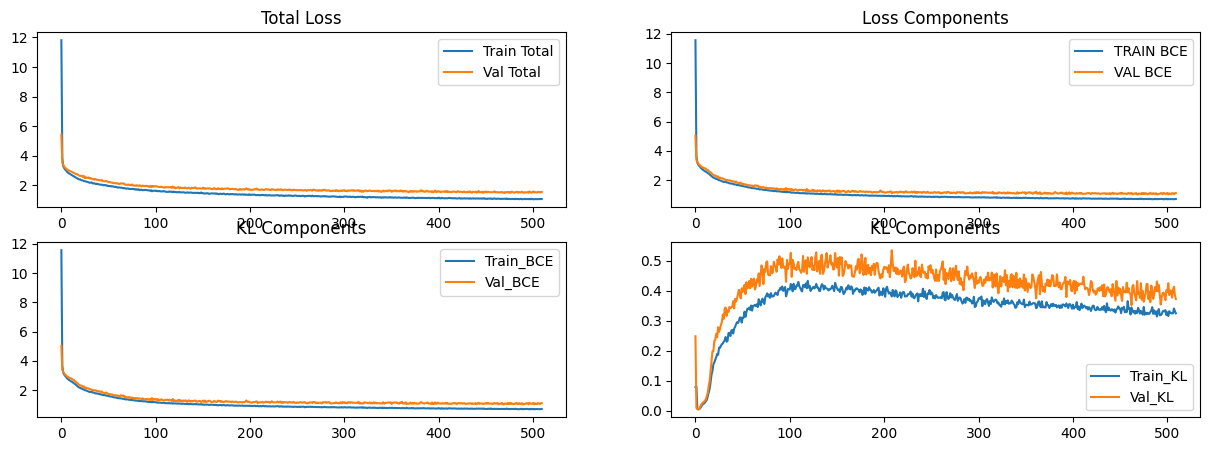

In [9]:
# 5. 결과 시각화
plt.figure(figsize=(15, 5))
plt.subplot(2, 2, 1)
plt.plot(history['train_loss'], label='Train Total')
plt.plot(history['val_loss'], label='Val Total')
plt.title('Total Loss')
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(history['train_bce'], label='TRAIN BCE')
plt.plot(history['val_bce'], label='VAL BCE')
plt.title('Loss Components')
plt.legend()

plt.subplot(2,2,3)
plt.plot(history['train_bce'],label ='Train_BCE')
plt.plot(history['val_bce'], label = 'Val_BCE')
plt.title('KL Components')
plt.legend()
plt.subplot(2,2,4)
plt.plot(history['train_kl'],label ='Train_KL')
plt.plot(history['val_kl'], label = 'Val_KL')
plt.title('KL Components')
plt.legend()
plt.show()

In [10]:
import joblib
import torch
import numpy as np
import pandas as pd
from sklearn.metrics import r2_score, mean_absolute_error
x_scaler = joblib.load('torch/ab_x_scaler.pkl')

In [11]:
from bce_metrics.bce_solve import eval_bce_metrics

In [12]:
early_stopping.load_best_model(model)
model.eval()

x_true = []
x_pred = []
all_x_true_bce = []
all_x_pred_bce = []
with torch.no_grad():
    for x_t, c_t in test_loader:
        x_t,c_t = x_t.to(device),c_t.to(device)
        bce_logit,binary_out, x_hat,z_mu,z_logvar = model(x_t,c_t)
        prob_mask = torch.sigmoid(bce_logit)
        x_true_bce = (x_t>0).float()
        all_x_pred_bce.append(bce_logit.detach().cpu())
        all_x_true_bce.append(x_true_bce.detach().cpu())
        x_true.append(x_t.cpu().numpy())
        x_pred.append(x_hat.cpu().numpy())
all_x_true = np.vstack(x_true)
all_x_hat = np.vstack(x_pred)
all_x_pred_bce = torch.cat([a.flatten() for a in all_x_pred_bce])
all_x_true_bce = torch.cat([a.flatten() for a in all_x_true_bce])
metrics = eval_bce_metrics(all_x_pred_bce,all_x_true_bce,threshold = 0.5)
metrics


Restored best model with loss: 1.477978


{'threshold': 0.5,
 'bce': 0.0447903573513031,
 'tp': 1567,
 'fp': 148,
 'tn': 25230,
 'fn': 241,
 'precision': 0.9137026239013779,
 'recall': 0.8667035398182152,
 'f1': 0.8895827369797001,
 'accuracy': 0.9856911645696367}

In [13]:
import json

# metrics 결과 저장
save_path = "re_f1_metrics.json"

with open(save_path, 'w') as f:
    json.dump(metrics, f, indent=4)

print(f"지표가 {save_path}에 저장되었습니다.")

지표가 re_f1_metrics.json에 저장되었습니다.


In [14]:
x_true_raw = x_scaler.inverse_transform(all_x_true)
x_hat_raw = x_scaler.inverse_transform(all_x_hat)

In [15]:
from sklearn.metrics import r2_score, mean_squared_error
x_true = all_x_true.flatten()
x_pred = all_x_hat.flatten()
rmse = np.sqrt(mean_squared_error(x_true,x_pred))
r2 = r2_score(x_true,x_pred)
history = {'RMSE':round(float(rmse),4),'R2':round(float(r2),4)}

In [16]:
import json

save_path = "re_no_metrics.json"

with open(save_path, 'w') as f:
    # float 타입 데이터도 json.dump를 통해 안전하게 저장됩니다.
    json.dump(history, f, indent=4)

print(f"숫자 형태로 {save_path}에 저장 완료!")

숫자 형태로 re_no_metrics.json에 저장 완료!


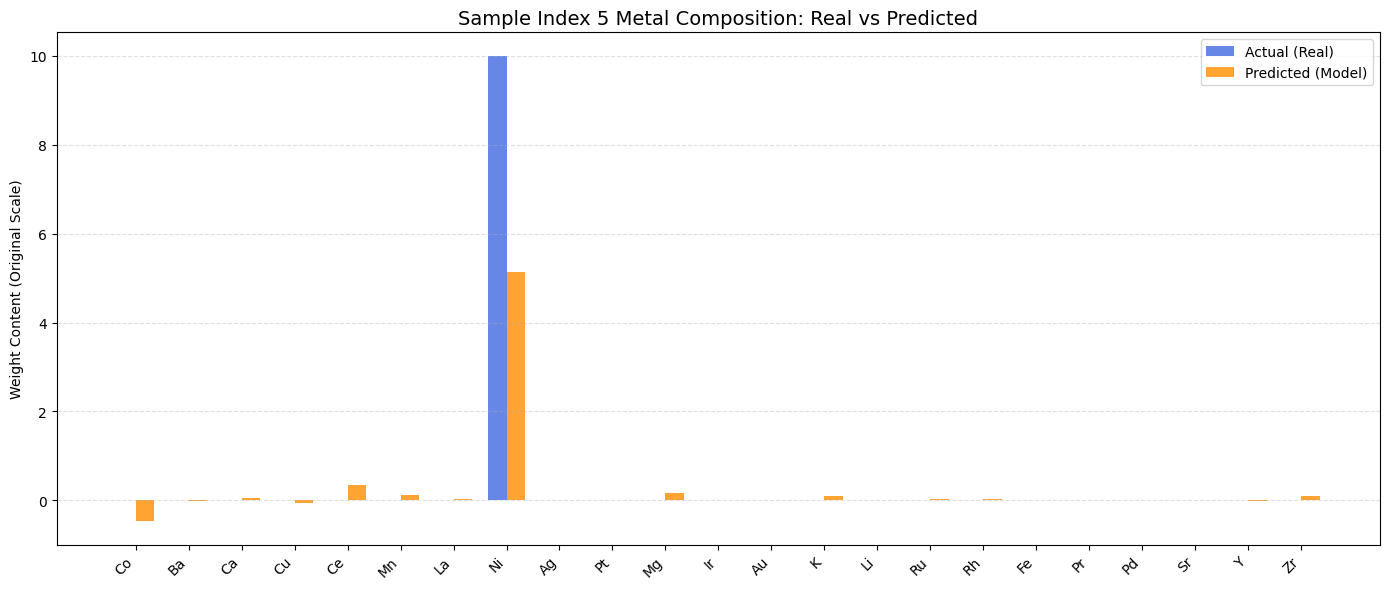

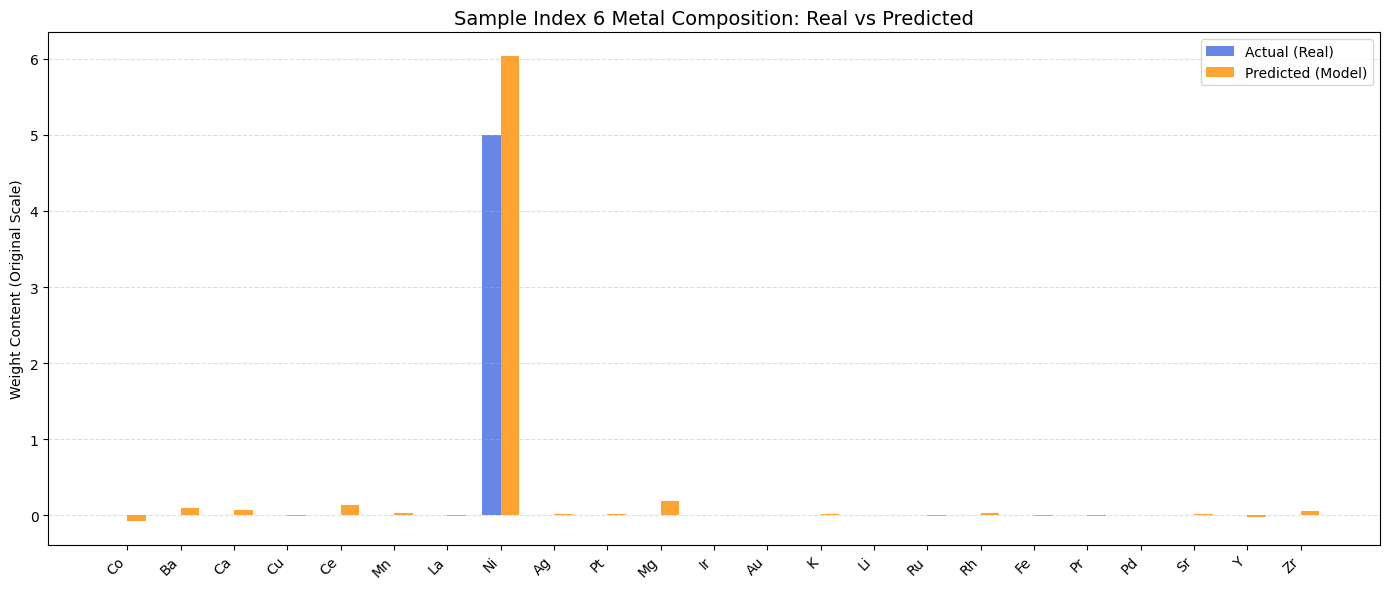

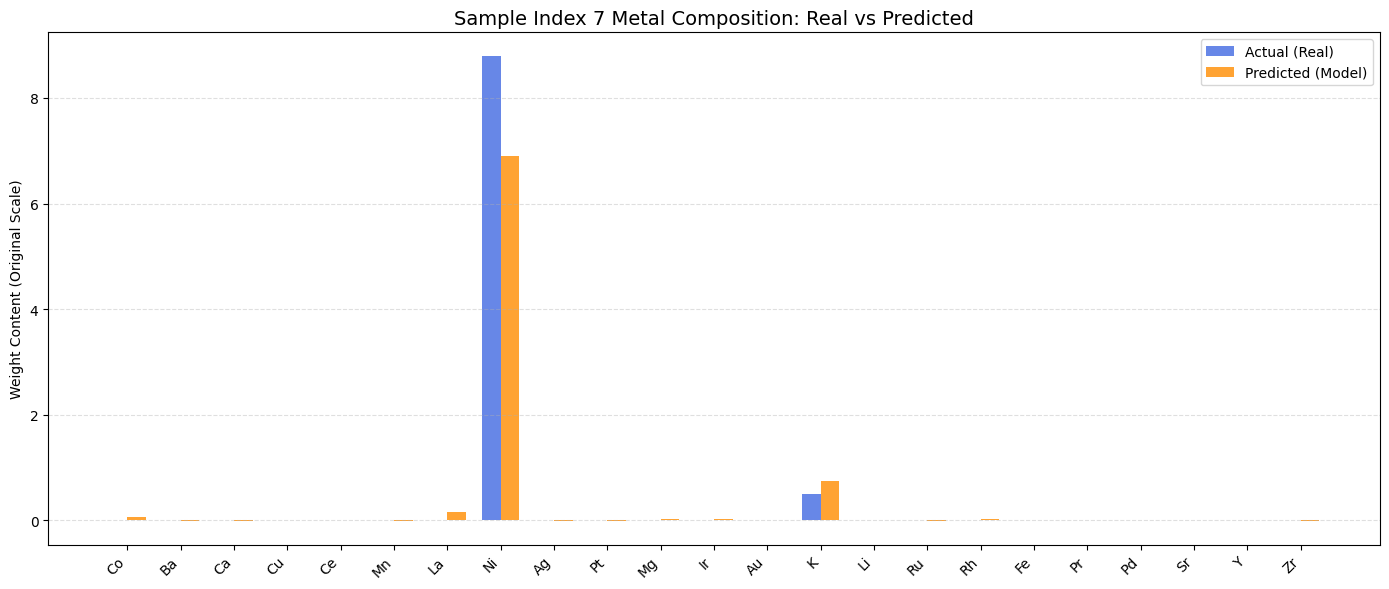

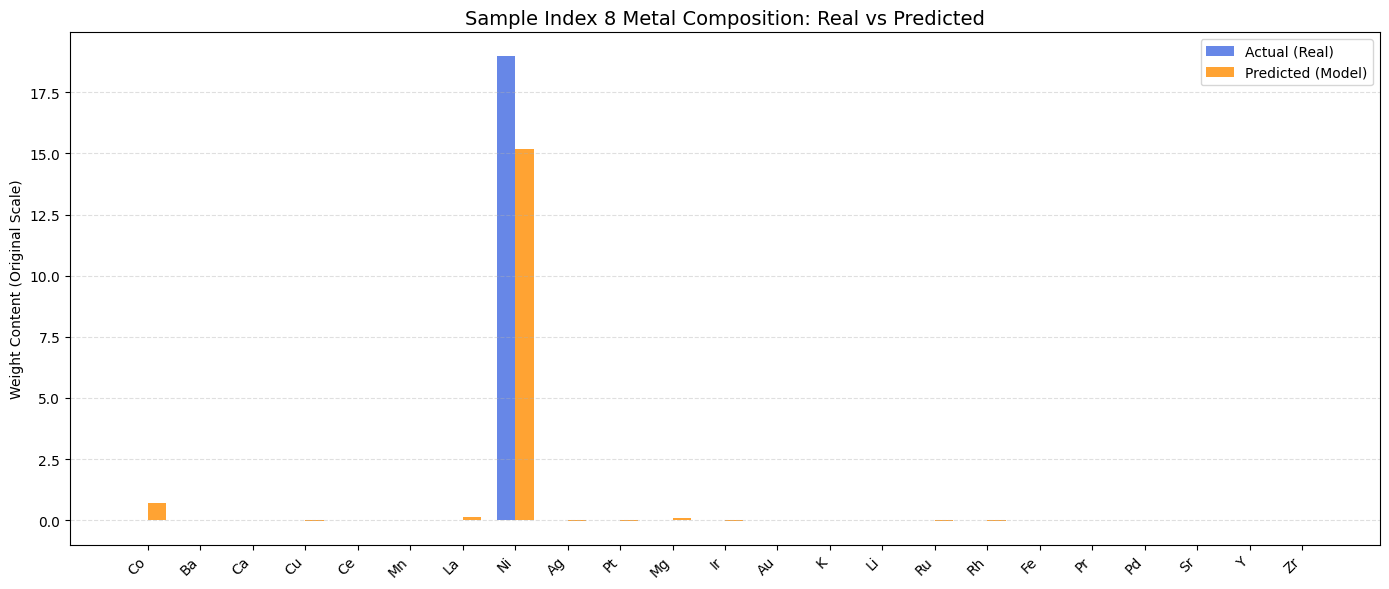

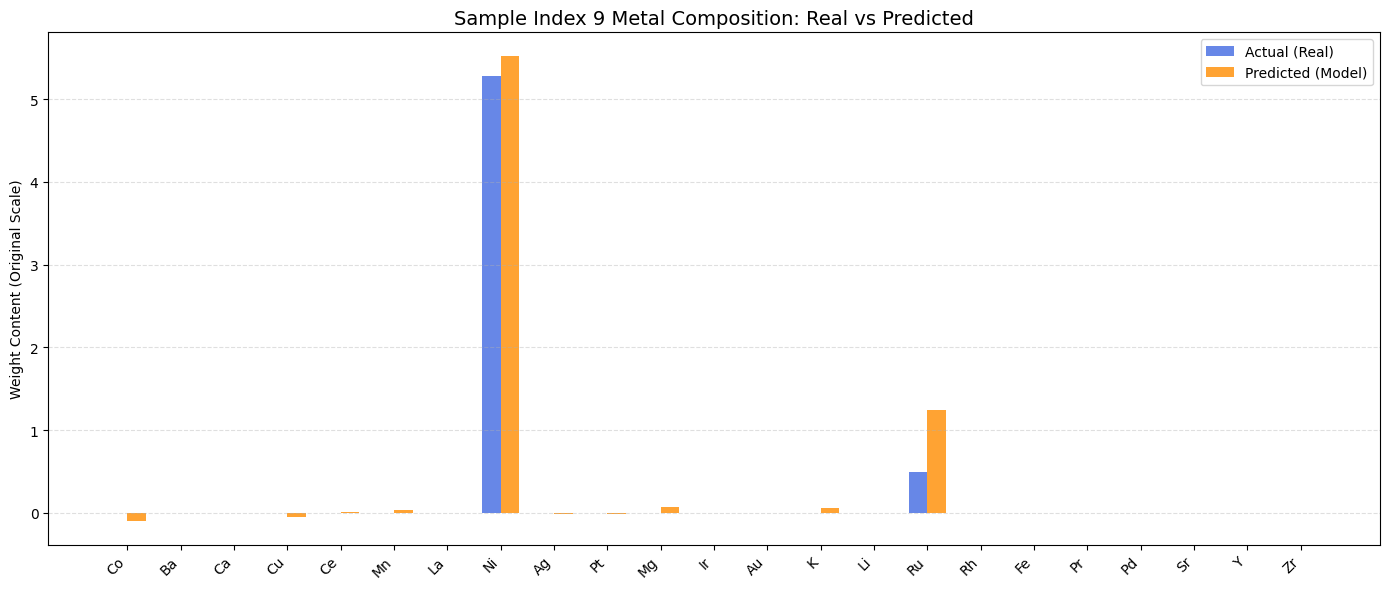

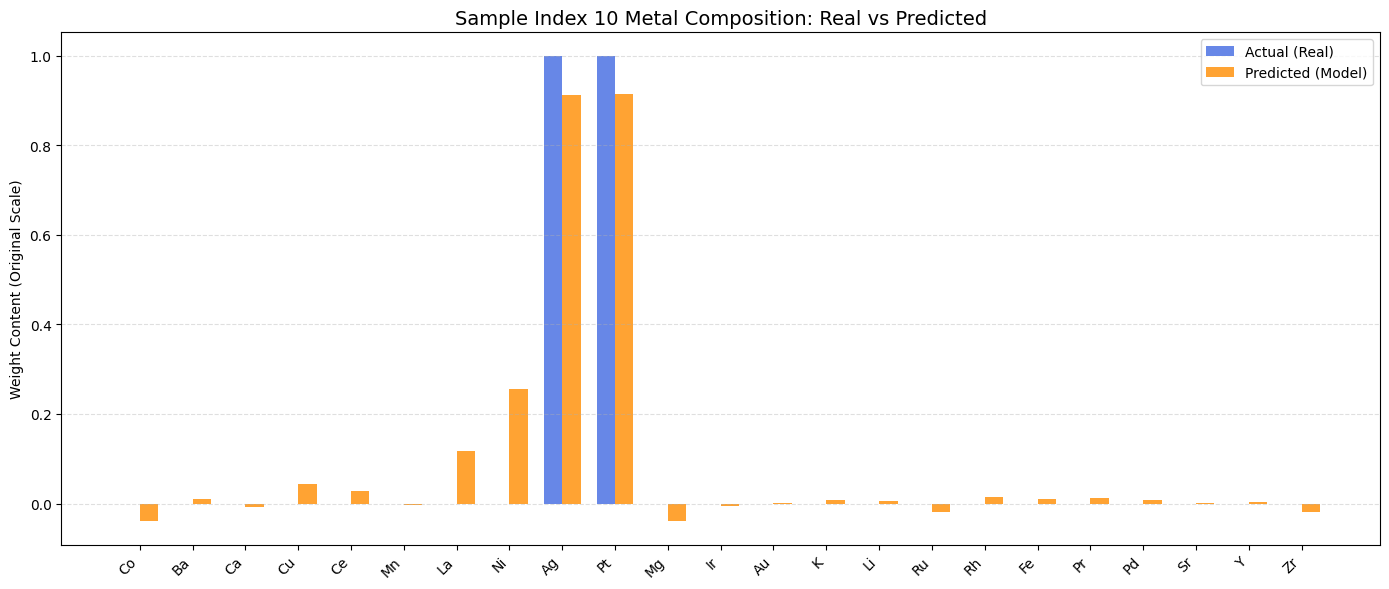

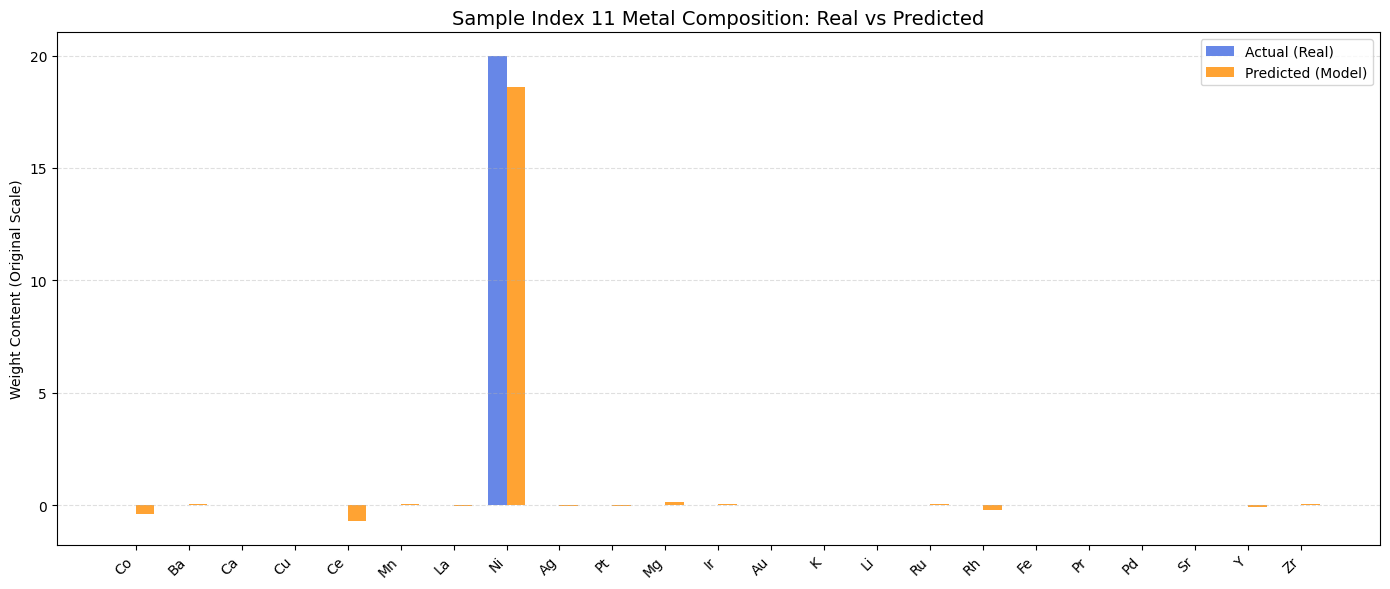

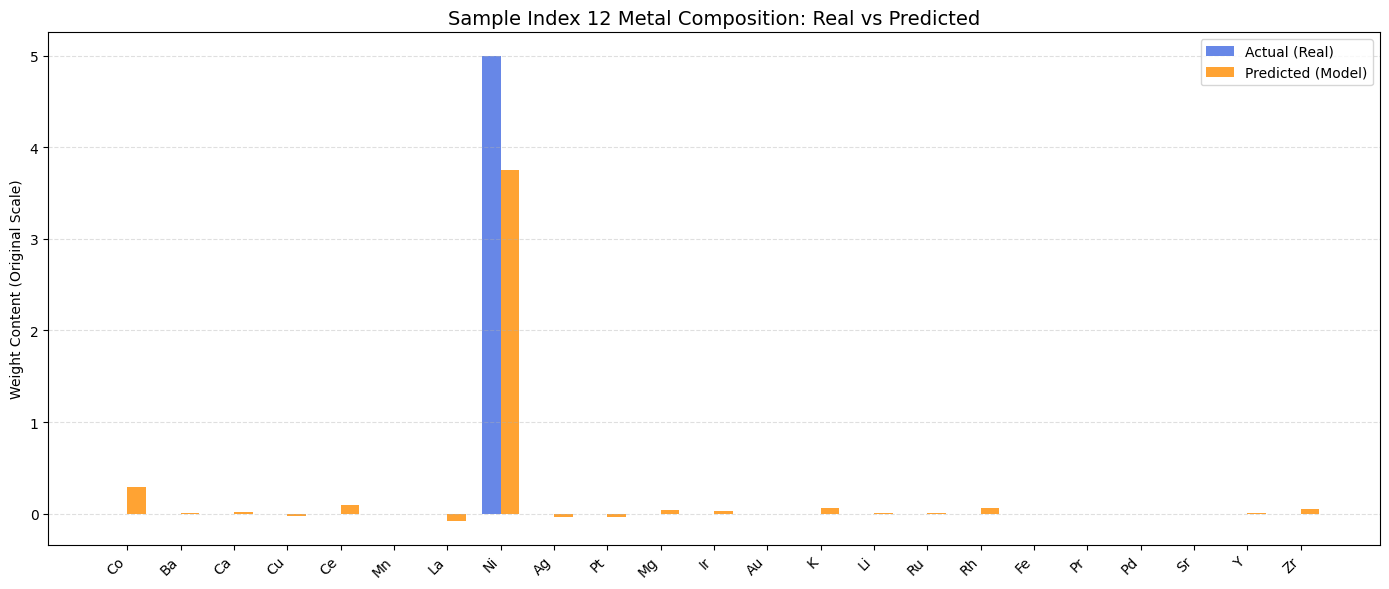

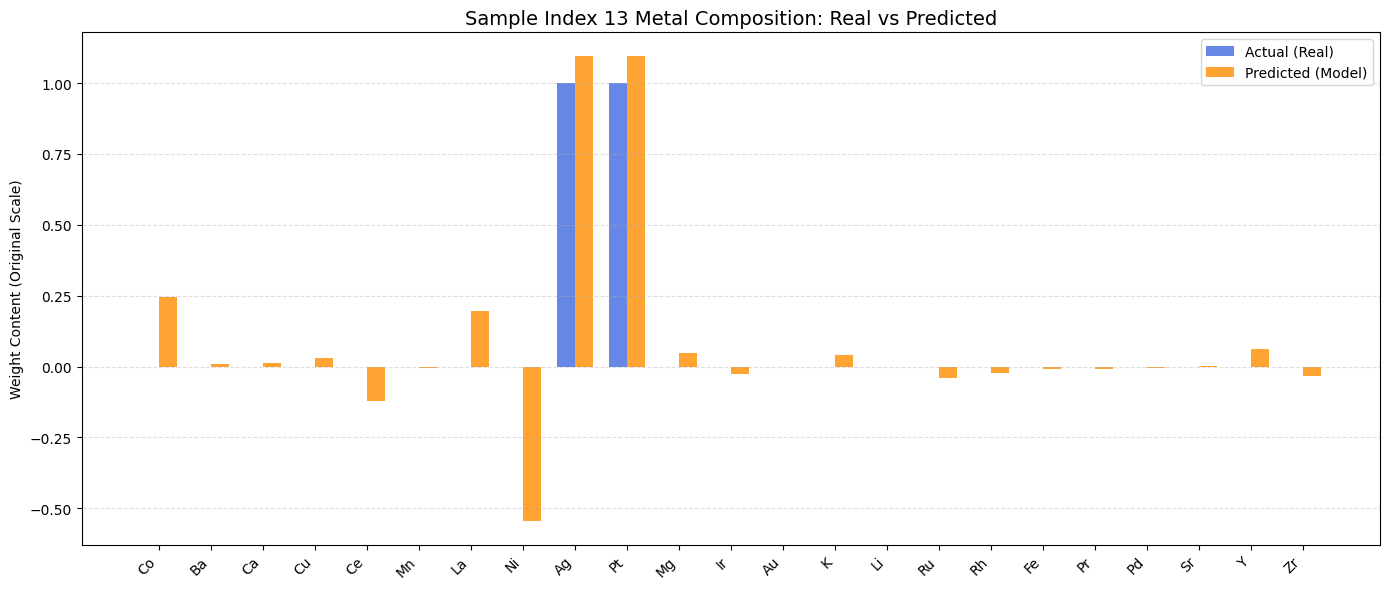

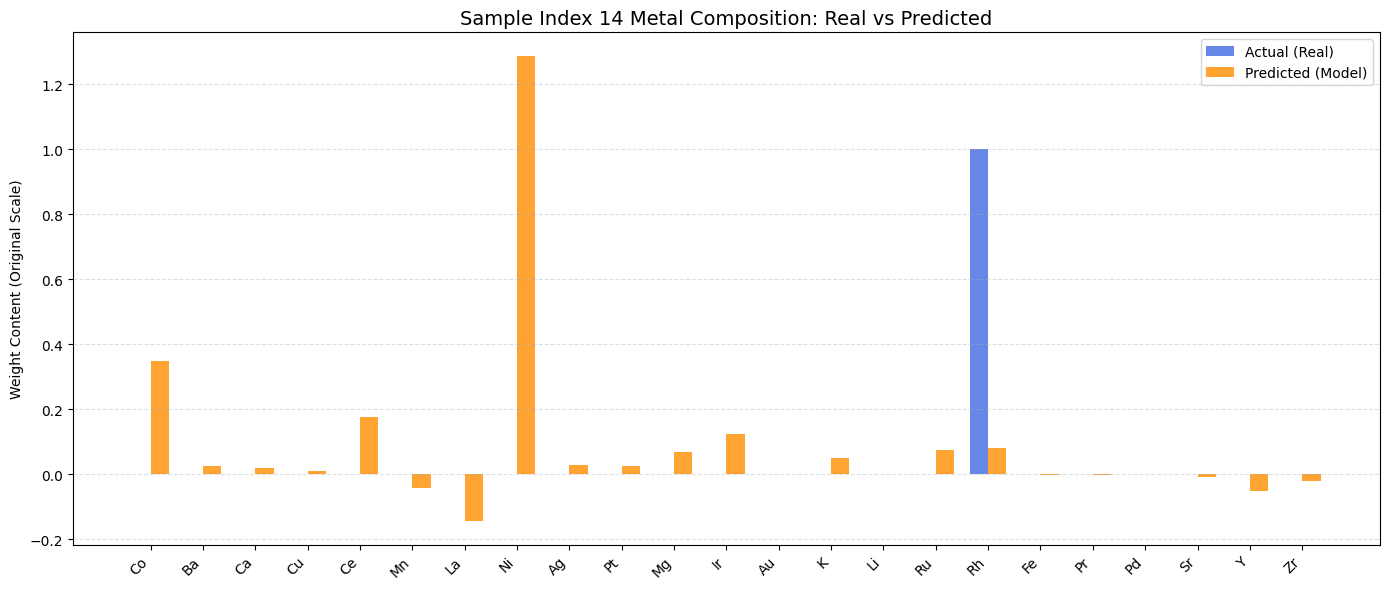

In [17]:
df_meta = pd.read_csv('211210-DRM-total.csv')
df_metal = df_meta.iloc[:,2:25]
metal_columns = df_metal.columns
for i in range(5, 15):
    plt.figure(figsize=(14, 6))
    x_axis = np.arange(23)
    width = 0.35
    
    plt.bar(x_axis - width/2,x_true_raw[i], width, label='Actual (Real)', color='royalblue', alpha=0.8)
    plt.bar(x_axis + width/2, x_hat_raw[i], width, label='Predicted (Model)', color='darkorange', alpha=0.8)
    
    plt.xticks(x_axis, metal_columns, rotation=45, ha='right')
    plt.title(f'Sample Index {i} Metal Composition: Real vs Predicted', fontsize=14)
    plt.ylabel('Weight Content (Original Scale)')
    plt.legend()
    plt.grid(axis='y', linestyle='--', alpha=0.4)
    plt.tight_layout()
    plt.show()